In [1]:
import os
import sys

import pandas as pd
import requests

import time
import json

import seaborn as sns

In [21]:
path_to_config = "./strategies/delta-hedge/configs/concentrated_liquidity_config.json"
with open(path_to_config) as f:
    config = json.load(f)

deriv_params = {
    "asset": config["asset"],
    "initial_asset_price": config["initial_asset_price"],
    "long_only": config["long_only"],
}

In [1]:
class Derivative:
    def __init__(self, name, payoff_fun, bid, ask, info):
        self.name = name
        self.payoff_fun = payoff_fun
        self.deribit_info = info
        self.bid = bid
        self.ask = ask

In [15]:
def retrieve_instruments(currency, expired=False):
    assert currency in ["ETH", "SOL", "BTC"]
    expired = "true" if expired else "false"
    instruments = requests.get(
        "https://deribit.com/api/v2/public/get_book_summary_by_currency?currency={}&kind=option".format(currency)
    ).json()["result"]
    return instruments

currency = 'ETH'
instruments = retrieve_instruments(currency=currency)
print('Total of {} instruments for {} available on Deribit'.format(len(instruments), currency))

Total of 718 instruments for ETH available on Deribit


In [2]:
df_instrument = pd.DataFrame(instruments)
df_instrument.to_csv('./data/deribit_instruments.csv')
df_instrument

NameError: name 'instruments' is not defined

In [3]:
df_instrument = pd.read_csv('./data/deribit_instruments.csv', index_col=[0])
df_instrument

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,price_change,mark_price,open_interest,ask_price,bid_price,instrument_name,last,low,high
0,0.02975,2307.91,274.52,ETH,1703393241971,ETH,0.0,4.0,ETH-29MAR24,2388.450000,0.0000,0.029822,16106.0,0.0310,0.0285,ETH-29MAR24-1800-P,0.0300,0.0300,0.0300
1,0.02775,2307.91,35078.64,ETH,1703393241971,ETH,0.0,518.0,SYN.ETH-12JAN24,2328.810000,-8.3333,0.028009,1374.0,0.0280,0.0275,ETH-12JAN24-2200-P,0.0275,0.0275,0.0300
2,0.00105,2307.91,25.10,ETH,1703393241971,ETH,0.0,16.0,SYN.ETH-26DEC23,2310.529823,75.0000,0.000997,16.0,0.0012,0.0009,ETH-26DEC23-2500-C,0.0007,0.0004,0.0007
3,0.08325,2307.91,4632.38,ETH,1703393241971,ETH,0.0,24.0,SYN.ETH-23FEB24,2362.832222,0.5952,0.083402,1052.0,0.0840,0.0825,ETH-23FEB24-2300-P,0.0845,0.0815,0.0845
4,0.00040,2307.91,293.38,ETH,1703393241972,ETH,0.0,160.0,SYN.ETH-25DEC23,2309.236431,-84.0000,0.000375,141.0,0.0006,0.0002,ETH-25DEC23-2225-P,0.0004,0.0004,0.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.00015,2307.91,116.33,ETH,1703393241982,ETH,0.0,123.0,SYN.ETH-25DEC23,2309.236431,-50.0000,0.000281,181.0,0.0002,0.0001,ETH-25DEC23-2175-P,0.0003,0.0003,0.0006
714,0.00090,2307.91,0.00,ETH,1703393241982,ETH,0.0,0.0,ETH-28JUN24,2442.140000,NaN,0.000909,402.0,0.0015,0.0003,ETH-28JUN24-500-P,0.0015,NaN,NaN
715,0.04650,2307.91,0.00,ETH,1703393241982,ETH,0.0,0.0,SYN.ETH-26DEC23,2310.529823,NaN,0.051786,0.0,0.0630,0.0300,ETH-26DEC23-2425-P,NaN,NaN,NaN
716,NaN,2307.91,0.00,ETH,1703393241982,ETH,0.0,0.0,SYN.ETH-23FEB24,2362.832222,NaN,0.452430,0.0,NaN,NaN,ETH-23FEB24-1300-C,NaN,NaN,NaN


In [4]:
df_instrument[['currency', 'expire_date', 'strike_price', 'option_type']] = df_instrument.instrument_name.str.split('-', expand=True)
df_instrument

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,ask_price,bid_price,instrument_name,last,low,high,currency,expire_date,strike_price,option_type
0,0.02975,2307.91,274.52,ETH,1703393241971,ETH,0.0,4.0,ETH-29MAR24,2388.450000,...,0.0310,0.0285,ETH-29MAR24-1800-P,0.0300,0.0300,0.0300,ETH,29MAR24,1800,P
1,0.02775,2307.91,35078.64,ETH,1703393241971,ETH,0.0,518.0,SYN.ETH-12JAN24,2328.810000,...,0.0280,0.0275,ETH-12JAN24-2200-P,0.0275,0.0275,0.0300,ETH,12JAN24,2200,P
2,0.00105,2307.91,25.10,ETH,1703393241971,ETH,0.0,16.0,SYN.ETH-26DEC23,2310.529823,...,0.0012,0.0009,ETH-26DEC23-2500-C,0.0007,0.0004,0.0007,ETH,26DEC23,2500,C
3,0.08325,2307.91,4632.38,ETH,1703393241971,ETH,0.0,24.0,SYN.ETH-23FEB24,2362.832222,...,0.0840,0.0825,ETH-23FEB24-2300-P,0.0845,0.0815,0.0845,ETH,23FEB24,2300,P
4,0.00040,2307.91,293.38,ETH,1703393241972,ETH,0.0,160.0,SYN.ETH-25DEC23,2309.236431,...,0.0006,0.0002,ETH-25DEC23-2225-P,0.0004,0.0004,0.0025,ETH,25DEC23,2225,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.00015,2307.91,116.33,ETH,1703393241982,ETH,0.0,123.0,SYN.ETH-25DEC23,2309.236431,...,0.0002,0.0001,ETH-25DEC23-2175-P,0.0003,0.0003,0.0006,ETH,25DEC23,2175,P
714,0.00090,2307.91,0.00,ETH,1703393241982,ETH,0.0,0.0,ETH-28JUN24,2442.140000,...,0.0015,0.0003,ETH-28JUN24-500-P,0.0015,NaN,NaN,ETH,28JUN24,500,P
715,0.04650,2307.91,0.00,ETH,1703393241982,ETH,0.0,0.0,SYN.ETH-26DEC23,2310.529823,...,0.0630,0.0300,ETH-26DEC23-2425-P,NaN,NaN,NaN,ETH,26DEC23,2425,P
716,NaN,2307.91,0.00,ETH,1703393241982,ETH,0.0,0.0,SYN.ETH-23FEB24,2362.832222,...,NaN,NaN,ETH-23FEB24-1300-C,NaN,NaN,NaN,ETH,23FEB24,1300,C


In [123]:
df_instrument['option_type'].value_counts()

P    359
C    359
Name: option_type, dtype: int64

In [34]:
# df_instrument[['currency', 'expire_date', 'strike_price', 'option_type']]
df_instrument['strike_price'] = df_instrument['strike_price'].astype('float')

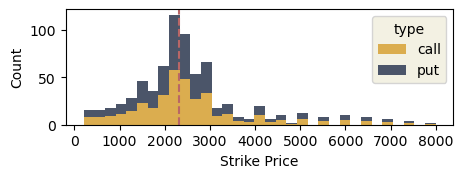

In [70]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(5,1.5))
# Setting the background color of the plot 
ax = plt.axes()
# ax.set_facecolor("#F0EEDC")

sns.histplot(data=df_instrument, x='strike_price', hue='option_type', multiple="stack", 
             palette=['#4B5569', '#DBAD4F'], edgecolors=None, alpha=1)

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

legend = plt.legend(title='type', loc='upper right', labels=['call', 'put'])
frame = legend.get_frame()
frame.set_facecolor("#F0EEDC")

plt.axvline(x=df_instrument.estimated_delivery_price.mean(), color='#B96666', linestyle='--')

plt.ylabel('Count')
plt.xlabel('Strike Price')
plt.savefig('./img/strike_price.png', dpi=500, bbox_inches='tight', transparent=True)

In [73]:
month_dict = {'JAN': '-01-', 'FEB': '-02-', 'MAR': '-03-', 'APR': '-04-', 'MAY': '-05-', 'JUN': '-06-',
              'JUL': '-07-', 'AUG': '-08-', 'SEP': '-09-', 'OCT': '-10-', 'NOV': '-11-', 'DEC': '-12-'}

In [75]:
for i in month_dict:
    df_instrument['expire_date'] = df_instrument['expire_date'].str.replace(i, month_dict[i])

In [76]:
# df_instrument[['currency', 'expire_date', 'strike_price', 'option_type']]
df_instrument['expire_date'] = pd.to_datetime(df_instrument['expire_date'])

In [116]:
df_expire = df_instrument.groupby(['expire_date'])['instrument_name'].count().reset_index()
df_expire['instrument_name_each'] = df_expire['instrument_name'] / 2
df_expire

,expire_date,instrument_name,instrument_name_each
0,2023-12-24,60,30.0
1,2023-12-25,62,31.0
2,2023-12-26,60,30.0
3,2023-12-29,74,37.0
4,2024-01-26,72,36.0
5,2024-02-23,74,37.0
6,2024-03-29,62,31.0
7,2024-05-01,74,37.0
8,2024-06-28,64,32.0
9,2024-09-27,68,34.0


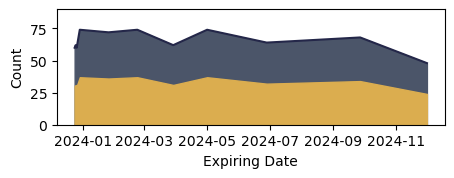

In [122]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(5,1.5))
# Setting the background color of the plot 
ax = plt.axes()
# ax.set_facecolor("#F0EEDC")

sns.lineplot(data=df_expire, x='expire_date', y='instrument_name', color='#242749')

ax.fill_between(df_expire.expire_date, 0, df_expire.instrument_name, color='#4B5569')
ax.fill_between(df_expire.expire_date, 0, df_expire.instrument_name_each, color='#DBAD4F')

plt.ylabel('Count')
plt.xlabel('Expiring Date')
plt.ylim([0, 90])
plt.savefig('./img/expire_date.png', dpi=500, bbox_inches='tight', transparent=True)

In [3]:
# LP_DELTA_HEDGE_PATH = os.path.dirname(
#     os.path.dirname(os.path.dirname(os.path.realpath(__file__)))
# )
# sys.path.append(LP_DELTA_HEDGE_PATH + "/src")


def create_derivatives_for_instrument(instrument_data, initial_asset_price):
    name = instrument_data["instrument_name"]
    if (
        not (name.endswith("C") or name.endswith("P"))
        or (instrument_data["bid_price"] is None)
        or (instrument_data["ask_price"] is None)
    ):
        return None, None
    strike = int(name.split("-")[-2])
    best_bid = instrument_data["bid_price"] * initial_asset_price
    best_ask = instrument_data["ask_price"] * initial_asset_price
    info = {"instrument_data": instrument_data}
    long_payoff_fun = None
    short_payoff_fun = None
    # call
    if name.endswith("C"):
        # long
        long_payoff_fun = lambda x: max(0, x - strike) - best_ask
        # short
        short_payoff_fun = lambda x: best_bid - max(0, x - strike)
    else:  # put
        # long
        long_payoff_fun = lambda x: max(0, strike - x) - best_ask
        # short
        short_payoff_fun = lambda x: best_bid - max(0, strike - x)
    long_deriv = Derivative(name + "_LONG", long_payoff_fun, best_bid, best_ask, info)
    short_deriv = Derivative(
        name + "_SHORT", short_payoff_fun, best_bid, best_ask, info
    )
    return long_deriv, short_deriv


def create_derivatives_from_instrument_data(data, initial_asset_price, long_only):
    assert type(data) == list
    derivatives = []
    for instrument in data:
        long_deriv, short_deriv = create_derivatives_for_instrument(
            instrument, initial_asset_price
        )
        if long_deriv is None or short_deriv is None:
            continue
        derivatives.append(long_deriv)
        if not long_only:
            derivatives.append(short_deriv)
    return derivatives


def retrieve_and_create_derivatives(currency, initial_asset_price, long_only):
    instruments = retrieve_instruments(currency)
    derivs = create_derivatives_from_instrument_data(
        instruments, initial_asset_price, long_only
    )
    return derivs


In [4]:

start_time = time.time()

derivs = retrieve_and_create_derivatives(
    deriv_params["asset"],
    deriv_params["initial_asset_price"],
    deriv_params["long_only"],
)

print(f"Derivatives fetched ({int(time.time() - start_time)} sec)...", flush=True)

Derivatives fetched (2 sec)...


In [5]:
derivs